In [1]:
%matplotlib inline

## Basic Usage

In [ ]:
from matplotlib.figure import Figure
from fbd_plotting import plot_beam_fbd, plot_enveloped_forces

fig = Figure(figsize=(16, 8))
fig.tight_layout()
fig.subplots_adjust(bottom=6, top=7) # Can't remember if this did anything useful or not

axes = fig.subplots(3, 1) # Axes grid: 3 rows, 1 column

analysis_model = ... # Pynite.FEModel3D Your pynite model here
enveloping_load_combos = ... # list[str], Your list of load combos here
featured_load_combo = ... # str, the load combo you want in a red line

axes[0] = plot_beam_fbd(analysis_model, axes[0]) # Populate the top axes
axes[1] = plot_enveloped_forces(axes[1], analysis_model, "shear", enveloping_load_combos, featured_load_combo) # Populate the middle axes
axes[2] = plot_enveloped_forces(axes[2], analysis_model, "moment", enveloping_load_combos, featured_load_combo) # Populate the bottom axes

## How I have been using it

In [2]:
import jsonchain
import pynite_tools as pt

# Chaining in
models = jsonchain.load_json('models.json')
load_combos = jsonchain.load_json("load_combos.json")

# Member selection
member_name = mn = 'FB0.1'

# Filtering load combos
uls_combos = [load_combo['name'] for load_combo in load_combos if "ULS" in load_combo['name']]
sls_combos = [load_combo['name'] for load_combo in load_combos if "SLS" in load_combo['name']]

analysis_model = am = pt.load_dict(models[mn])
pt.combos.model_add_combos(load_combos, analysis_model)
analysis_model.analyze()

In [3]:
## Envelope my results with pynite_tools and jsonchain
## This simplifies my json data and tells me which load combo generates the absmax shear/moment

# Force demand
force_env = pt.extract_member_envelopes(am, load_combinations=uls_combos, actions=['Fy', 'Mz'])

# Shear envelope
shear_envelope = jsonchain.envelope_tree(
    force_env, 
    levels=[None, 'action_envelopes', 'Fy'], 
    leaf='absmax', 
    agg_func=jsonchain.max
)
shear_demand = {
    mn: {
        "factored": shear_envelope[mn]['action_envelopes']['Fy']['value'], 
        "LC":  shear_envelope[mn]['action_envelopes']['Fy']['key'],
    }
}

# Moment envelope
moment_envelope = jsonchain.envelope_tree(
    force_env, 
    levels=[None, 'action_envelopes', 'Mz'], 
    leaf='absmax', 
    agg_func=jsonchain.max
)
moment_demand = {
    mn: {
        "factored": moment_envelope[mn]['action_envelopes']['Mz']['value'], 
        "LC":  moment_envelope[mn]['action_envelopes']['Mz']['key'],
    }
}

In [4]:
from matplotlib.figure import Figure
from fbd_plotting import plot_beam_fbd, plot_enveloped_forces

fig = Figure(figsize=(16, 8))
fig.tight_layout()
fig.subplots_adjust(bottom=6, top=7) # Can't remember if this did anything useful or not

axes = fig.subplots(3, 1) # Axes grid: 3 rows, 1 column

governing_shear_combo = shear_demand[mn]['LC']
governing_moment_combo = moment_demand[mn]['LC']

axes[0] = plot_beam_fbd(analysis_model, axes[0]) # Populate the top axes
axes[1] = plot_enveloped_forces(axes[1], analysis_model, "shear", uls_combos, governing_shear_combo) # Populate the middle axes
axes[2] = plot_enveloped_forces(axes[2], analysis_model, "moment", uls_combos, governing_moment_combo) # Populate the bottom axes

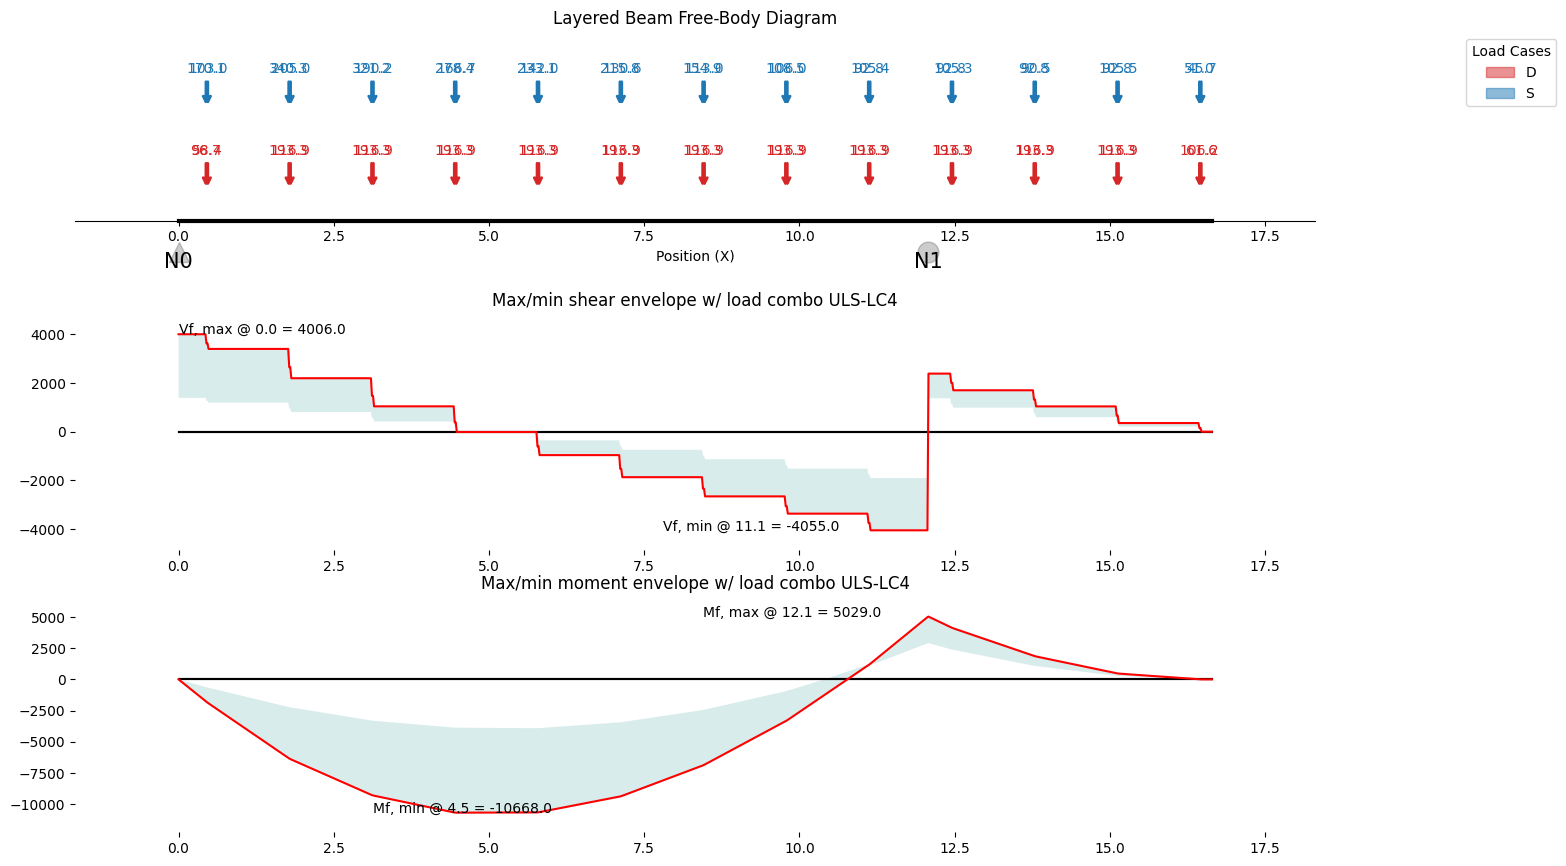

In [5]:
fig